In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess import *
from model import *
from tensorflow.keras import backend as K
import shap
from sklearn.model_selection import train_test_split
from shap_util import SlidingTimeWindow, BinaryTimeWindow, StationaryTimeWindow, timeshap_to_array
import timeit


%matplotlib inline
shap.initjs()

2022-11-02 00:12:27.488854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 00:12:27.488880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Synthetic data

In [2]:
def synthetic_data(n_samples=100, n_steps=10, n_features=4):
    # Creating input data
    lam = 0.2
    anomaly_lam = 10
    eps = np.random.normal
    x=np.zeros((n_samples, n_steps, n_features))
    labels = np.zeros(n_samples)
    for i in range(n_samples):
        t0 = np.random.randint(1, 5, size=n_features)
        w = np.random.randint(1, 5, size=n_features)
        t = np.arange(n_steps)
        for j in range(n_features):
            if j%2 == 0:
                x[i,:,j] = np.sin((t-t0[j])/w[j])
            else:
                x[i,:,j] = np.cos((t-t0[j])/w[j])
            x[i,:,j] = x[i,:,j] + lam*eps(size=n_steps)

        # adding anomaly
#         anom_dur = np.random.randint(n_steps/10, n_steps/2)
        anom_dur = 20
        anom_start = np.random.randint(0, n_steps - anom_dur)
        anom_end = anom_start + anom_dur
        
        anom_j = np.random.randint(0, n_features)
        x[i, anom_start:anom_end, anom_j] += anomaly_lam*eps(size=anom_dur)
        
        # Creating the label
        labels[i] = 1 if anom_j==0 else 0
    return x, labels

Data seperation to test and train

In [3]:
x, label = synthetic_data(n_samples=10000, n_steps=120, n_features=4)
train_x, test_x, train_y, test_y = train_test_split(x, label, test_size=0.3, random_state=0,
                                                    stratify=label)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0,
                                                 stratify=train_y)

LSTM Model

In [5]:
from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, GRU, TimeDistributed
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD

num_hidden = [70, 20]
num_neurons = 200
es_patience = 20
epochs = 40
num_output = 1
batch_size = 32
drop_rate = 0.3
reg_rate = 0.004

K.clear_session()
model = Sequential()
input_shape = (x.shape[1], x.shape[2])
model.add(GRU(units=num_neurons, activation='relu', input_shape=input_shape,
              recurrent_dropout=0.1, dropout=0.1))
for i in num_hidden:
    model.add(Dropout(drop_rate))
    model.add(Dense(units=i, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dense(units=num_output, activation='sigmoid'))

# Creating and compiling model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)

# Class weights
class_weights = {0:len(train_y)/(train_y==0).sum(),
                 1:len(train_y)/(train_y==1).sum()}

model.compile(optimizer=SGD(learning_rate=0.01, clipvalue=0.5), loss='binary_crossentropy',
              metrics=['accuracy'])
# model.build(input_shape)
model.summary()
train_history = model.fit(train_x, train_y, batch_size=batch_size,
                          epochs=epochs, verbose=2,
                          validation_data=(val_x, val_y),
                          class_weight=class_weights,
                          callbacks=[es])

2022-11-02 00:13:55.057567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-02 00:13:55.057602: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-02 00:13:55.057635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f38b2cf9ddbe): /proc/driver/nvidia/version does not exist
2022-11-02 00:13:55.057835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200)               123000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 70)                14070     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1420      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 138,511
Trainable params: 138,511
Non-trainable params: 0
__________________________________________________

2022-11-02 00:13:55.291818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-02 00:13:55.292369: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


175/175 - 18s - loss: 1.9125 - accuracy: 0.5204 - val_loss: 1.2065 - val_accuracy: 0.6400
Epoch 2/40
175/175 - 16s - loss: 1.8971 - accuracy: 0.5116 - val_loss: 1.1893 - val_accuracy: 0.7014
Epoch 3/40
175/175 - 16s - loss: 1.8820 - accuracy: 0.5759 - val_loss: 1.1795 - val_accuracy: 0.6071
Epoch 4/40
175/175 - 16s - loss: 1.8672 - accuracy: 0.5023 - val_loss: 1.1681 - val_accuracy: 0.5571
Epoch 5/40
175/175 - 16s - loss: 1.8541 - accuracy: 0.5309 - val_loss: 1.1596 - val_accuracy: 0.4000
Epoch 6/40
175/175 - 16s - loss: 1.8405 - accuracy: 0.4718 - val_loss: 1.1415 - val_accuracy: 0.5614
Epoch 7/40
175/175 - 16s - loss: 1.8249 - accuracy: 0.5184 - val_loss: 1.1250 - val_accuracy: 0.6550
Epoch 8/40
175/175 - 16s - loss: 1.8137 - accuracy: 0.5188 - val_loss: 1.1090 - val_accuracy: 0.6957
Epoch 9/40
175/175 - 16s - loss: 1.7998 - accuracy: 0.5584 - val_loss: 1.0983 - val_accuracy: 0.6779
Epoch 10/40
175/175 - 16s - loss: 1.7879 - accuracy: 0.5386 - val_loss: 1.0880 - val_accuracy: 0.6664


In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(roc_auc_score(test_y, model.predict(test_x)))
print(accuracy_score(test_y, np.round(model.predict(test_x))))

1.0
1.0


In [7]:
test_y[20:30]

array([0., 0., 1., 0., 0., 0., 1., 0., 1., 1.])

## SHAP interpretation

### 1- Stationary Time Window

In [8]:
num_background = 50
num_test = 28
background_data, test_data = train_x[:num_background], test_x[num_test:num_test+2]

In [13]:
tic = timeit.default_timer()
ts_phi = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 1
    gtw = StationaryTimeWindow(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='lstm')
    ts_phi[i,:,:] = gtw.shap_values()[0]
print('Total time: ' + str(timeit.default_timer()-tic))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time: 536.5355483591557


In [9]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    gtw = StationaryTimeWindow(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='lstm')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time: 365.163432045003


## 2- Sliding Time window

In [10]:
tic = timeit.default_timer()
ts_phi_2 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    stride = 10
    gtw = SlidingTimeWindow(model, stride, window_len, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_2[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time: 49.608465384997544


## 3- Binary Time window

In [22]:
tic = timeit.default_timer()
ts_phi_3 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.3
    n_w = 8
    btw = BinaryTimeWindow(model, delta, n_w, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_3[i,:,:] = btw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time: 223.78842280432582


## 4- TimeSHAP

In [62]:
tic = timeit.default_timer()
ts_phi_4 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    ts_phi_4[i,:,:] = timeshap_to_array(model.predict, train_x, test_x, test_data[i:i+1], var_to_ind=None,
                               top_x_events=300, top_x_feats=100)
print('Total time: ' + str(timeit.default_timer()-tic))

No path to explainer data provided. Calculating data
No path to event data provided. Calculating data
No path to feature data provided. Calculating data
No path to cell data provided. Calculating data
No path to explainer data provided. Calculating data
No path to event data provided. Calculating data
No path to feature data provided. Calculating data
No path to cell data provided. Calculating data
No path to explainer data provided. Calculating data
No path to event data provided. Calculating data
No path to feature data provided. Calculating data
No path to cell data provided. Calculating data
No path to explainer data provided. Calculating data
No path to event data provided. Calculating data
No path to feature data provided. Calculating data
No path to cell data provided. Calculating data
No path to explainer data provided. Calculating data
No path to event data provided. Calculating data
No path to feature data provided. Calculating data
No path to cell data provided. Calculating 

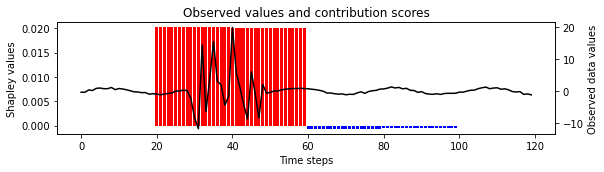

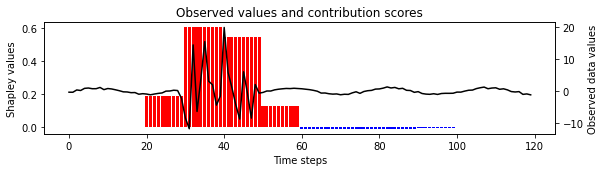

In [33]:
var = 0
phi_index = 0
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[phi_index, :, var], var_name='Observed', plot_type='bar')
# heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_4[phi_index, :, var], var_name='Variable', plot_type='bar')

In [86]:
btw.split_points

[[14, 29, 32, 34, 36, 38, 40, 42, 44, 47, 49, 51, 59, 119],
 [119],
 [119],
 [119]]

In [92]:
shap.force_plot(gtw.explainer.expected_value, ts_phi[phi_index].sum(axis=1))

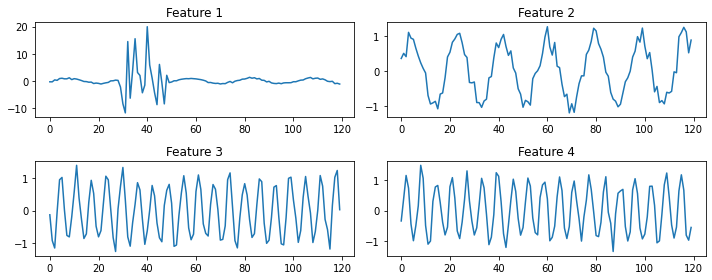

In [16]:
sample = 28
plt.rcParams["figure.figsize"] = 10,4
fig, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        axs[i, j].plot(test_x[sample, :200, (i * 2 + j)])
        axs[i, j].title.set_text('Feature {}'.format((i * 2 + j)+1))
plt.tight_layout()
plt.savefig('synthetic data.png')

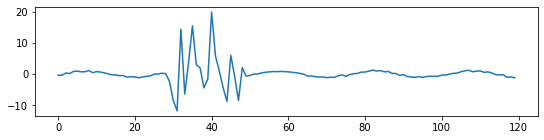

In [19]:
plt.rcParams["figure.figsize"] = 9,2
plt.plot(test_x[sample, :200, 0])

In [32]:
def heat_map(start, stop, x, shap_values, var_name='Feature 1', plot_type='bar', title=None):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import BoundaryNorm
    from textwrap import wrap
    import numpy as np; np.random.seed(1)
    
    ## ColorMap-------------------------
    # define the colormap
    cmap = plt.get_cmap('PuOr_r')

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize and forcing 0 to be part of the colorbar!
    bounds = np.arange(np.min(shap_values),np.max(shap_values),.005)
    idx=np.searchsorted(bounds,0)
    bounds=np.insert(bounds,idx,0)
    norm = BoundaryNorm(bounds, cmap.N)
    ##------------------------------------
    
    if title is None: title = '\n'.join(wrap('{} values and contribution scores'.format(var_name), width=40))
    
    if plot_type=='heat' or plot_type=='heat_abs':
        plt.rcParams["figure.figsize"] = 9,3
        if plot_type=='heat_abs':
            shap_values = np.absolute(shap_values)
            cmap = 'Reds'
        fig, ax1 = plt.subplots(sharex=True)
        extent = [start, stop, -2, 2]
        im1 = ax1.imshow(shap_values[np.newaxis, :], cmap=cmap, norm=norm, aspect="auto", extent=extent)
        ax1.set_yticks([])
        ax1.set_xlim(extent[0], extent[1])
        ax1.title.set_text(title)
        fig.colorbar(im1, ax=ax1, pad=0.1)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, color='black')
    elif plot_type=='bar':
        plt.rcParams["figure.figsize"] = 8.5,2.5
        fig, ax1 = plt.subplots(sharex=True)
        mask1 = shap_values < 0
        mask2 = shap_values >= 0
        ax1.bar(np.arange(start, stop)[mask1], shap_values[mask1], color='blue', label='Negative Shapley values')
        ax1.bar(np.arange(start, stop)[mask2], shap_values[mask2], color='red', label='Positive Shapley values')
        ax1.set_title(title)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, 'k-', label='Observed data')
        # legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax1.set_xlabel('Time steps')
    if plot_type=='bar': ax1.set_ylabel('Shapley values')
    ax2.set_ylabel(var_name + ' data values')
    plt.tight_layout()
    plt.show()

# Comparison of methods

In [101]:
from sklearn.metrics import mean_squared_error, f1_score, average_precision_score, log_loss
from copy import deepcopy
import math

In [102]:
def xai_eval_fnc(model, relevence, input_x, model_type='grud', percentile=90,
                 eval_type='prtb', seq_len=10, by='time'):
    
    input_new = deepcopy(input_x)
    relevence = np.absolute(relevence)
    
    # TO DO: Add other type of models
    if model_type == 'grud':
        input_ts = input_x[0]
        input_new_ts = input_new[0]
    elif model_type == 'lstm':
        input_ts = input_x
        input_new_ts = input_new
    
    assert len(input_ts.shape)==3 # the time sereis data needs to be 3-dimensional
    num_feature = input_ts.shape[2]
    num_time_step = input_ts.shape[1]
    num_instance = input_ts.shape[0]
        
    if by=='time':
        top_steps = math.ceil((1 - percentile/100) * num_time_step) # finding the number of top steps for each feature
        print(top_steps)
        top_indices = np.argsort(relevence, axis=1)[:, -top_steps:, :] # a 3d array of top time steps for each feature
        print(top_indices)
        for j in range(num_feature): # converting the indices to a flatten version
            top_indices[:, :, j] = top_indices[:, :, j] * num_feature + j
        top_indices = top_indices.flatten()
        print(top_indices)
    elif by=='all':
        top_steps = math.ceil((1 - percentile/100) * num_time_step * num_feature) # finding the number of all top steps
        top_indices = np.argsort(relevence, axis=None)[-top_steps:]

    
    # Create a masking matrix for top time steps
    top_indices_mask = np.zeros(input_ts.size)
    top_indices_mask[top_indices] = 1
    top_indices_mask = top_indices_mask.reshape(input_ts.shape)
    
    
    # Evaluating different metrics
    for p in range(num_instance):
        for v in range(num_feature):
            for t in range(num_time_step):
                if top_indices_mask[p, t, v]:
                    if eval_type == 'prtb':
                        input_new_ts[p,t,v] = np.max(input_ts[p,:,v]) - input_ts[p,t,v]
                    elif eval_type == 'sqnc_eval':
                        input_new_ts[p, t:t + seq_len, v] = np.mean(input_ts[p, t:t + seq_len, v])
    
    return model.predict(input_new)

In [103]:
loss_fun = 'BinaryCrossentropy'
by='all'
min_p = 60
max_p = 90
min_len = 10
max_len = 30
#-------------------------------------
if loss_fun == 'BinaryCrossentropy':
    loss = lambda x,y: log_loss(x,y,labels=[0,1])
elif loss_fun == 'mse':
    loss = mean_squared_error
elif loss_fun == 'f1':
    loss = lambda x, y: f1_score(x, np.round(y))
elif loss_fun == 'ap':
    loss = average_precision_score
#------------------------
num_instances = test_data.shape[0]

all_ts_phi = [ts_phi, ts_phi_1, ts_phi_2, ts_phi_3, ts_phi_4]

sqnc_evals = np.zeros((5, max_p - min_p, max_len - min_len))
prtb = np.zeros((5, max_p - min_p))

predict_y = model.predict(test_data)
true_y = test_y[num_test:num_test + num_instances]

for i in range(5):
    for p in range(min_p, max_p):
        temp_prtb = []
        for j in range(num_instances):
            temp_prtb.append(xai_eval_fnc(model=model, relevence=all_ts_phi[i][j:j+1],
                                          input_x=test_data[j:j+1], model_type='lstm',
                                          eval_type='prtb', percentile=p, by=by))
        temp_prtb = np.squeeze(temp_prtb)
        prtb[i, p-min_p] = loss(true_y, temp_prtb)/loss(true_y, predict_y)
        for seq_len in range(min_len, max_len):
            temp_sqnc = []
            for j in range(num_instances):
                temp_sqnc.append(xai_eval_fnc(model=model, relevence=all_ts_phi[i][j:j+1],
                                              input_x=test_data[j:j+1], model_type='lstm',
                                              eval_type='sqnc_eval', percentile=p, seq_len=seq_len, by=by))
            temp_sqnc = np.squeeze(temp_sqnc)
            sqnc_evals[i, p-min_p, seq_len-min_len] = loss(true_y, temp_sqnc)/loss(true_y, predict_y)
        print(f'Evaluation for percentile {p} is finished')
            

Evaluation for percentile 60 is finished
Evaluation for percentile 61 is finished
Evaluation for percentile 62 is finished
Evaluation for percentile 63 is finished
Evaluation for percentile 64 is finished
Evaluation for percentile 65 is finished
Evaluation for percentile 66 is finished
Evaluation for percentile 67 is finished
Evaluation for percentile 68 is finished
Evaluation for percentile 69 is finished
Evaluation for percentile 70 is finished
Evaluation for percentile 71 is finished
Evaluation for percentile 72 is finished
Evaluation for percentile 73 is finished
Evaluation for percentile 74 is finished
Evaluation for percentile 75 is finished
Evaluation for percentile 76 is finished
Evaluation for percentile 77 is finished
Evaluation for percentile 78 is finished
Evaluation for percentile 79 is finished
Evaluation for percentile 80 is finished
Evaluation for percentile 81 is finished
Evaluation for percentile 82 is finished
Evaluation for percentile 83 is finished
Evaluation for p

array([[0.00143042],
       [0.00378847],
       [0.99999934],
       [0.00415355],
       [0.99999905],
       [1.        ]], dtype=float32)

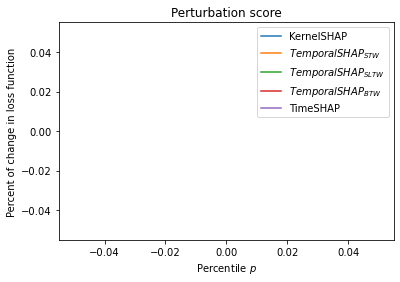

In [104]:
labels = ['KernelSHAP',r'$TemporalSHAP_{STW}$',r'$TemporalSHAP_{SLTW}$',r'$TemporalSHAP_{BTW}$','TimeSHAP']
plt.plot(np.arange(min_p, max_p), prtb.T, label=labels)
plt.xlabel(r'Percentile $p$')
plt.ylabel('Percent of change in loss function')
plt.title('Perturbation score')
plt.legend()
plt.show()

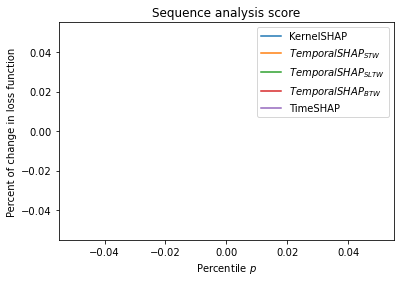

In [105]:
plt.plot(np.arange(min_p, max_p), sqnc_evals[:,:,0].T, label=labels)
plt.xlabel(r'Percentile $p$')
plt.ylabel('Percent of change in loss function')
plt.title('Sequence analysis score')
plt.legend()
plt.show()

In [106]:
prtb[4]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])